In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib  # 웹 데이터 다운로드 시 사용

from matplotlib import pyplot as plt
import tensorflow as tf

In [3]:
import os
img_path = '/home/aiffel0049/aiffel/Exploration/14.human_segmentation/images/image.jpg' 
img_orig = cv2.imread(img_path) 
print(img_orig.shape)

(540, 960, 3)


## Deeplab demo
- https://github.com/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb

In [4]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE=513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'
    
    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()
            
        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)
        
    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input

    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict = {
                self.INPUT_TENSOR_NAME:[img_input]
            }
        )
        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

## define model and download & load pretrained weight

In [5]:
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '/home/aiffel0049/aiffel/Exploration/14.human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print('temp directory', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                               download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory /home/aiffel0049/aiffel/Exploration/14.human_segmentation/models
model loaded successfully!


- 위의 경우는 PASCAL VOC 2012 데이터셋으로 학습된 v3 버전
- 다양한 데이터셋과 백본(backbone)에 따른 pretrained weight   
    https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/model_zoo.md

In [6]:
img_resized, seg_map = MODEL.run(img_orig)
print(img_orig.shape, img_resized.shape, seg_map.max())

(540, 960, 3) (288, 513, 3) 15


In [7]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

- background 제외 시 20개의 클래스
- 20 = tv

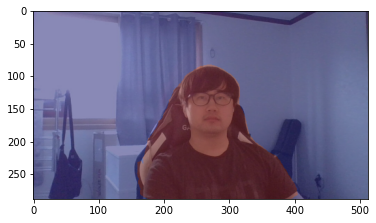

In [8]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)  # 예측 중 사람만 추출
img_mask = seg_map * (255 / seg_map.max())  # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- person인 15번 라벨만 검출
- 15번 레이블을 제외한 예측은 0으로 설정
- 예측된 segmentation image(map)의 최대값 = 15
- 픽셀값을 255로 정규화 -> applyColorMap()로 색을 적용, 이미지를 화면에 출력

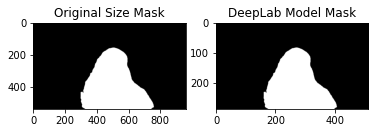

In [9]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1, 2, 1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1, 2, 2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

- cv2.resize()로 원본 복원
- 크기를 키울 때, interpolation을 고려해야 함
    - https://opencv-python.readthedocs.io/en/latest/doc/10.imageTransformation/imageTransformation.html
    - 보간법 : 이미지 크기를 변경하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법
    - cv2.INTER_NEAREST : 깔끔히 처리 가능
    - cv2.INTER_LINEAR : 정확히 확대 가능
<br><br>
- img_mask_up : 경계가 블러된 픽셀값 0~255의 이미지를 얻음
    - 중간값인 128을 기준으로 임계값(threshold)을 설정
    - 128이하 -> 0으로 설정
    - 128이상 -> 255로 설정

## 배경 추출

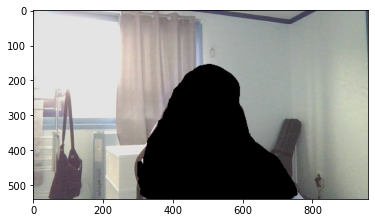

In [10]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

- bitwise_not, bitwise_and 로 이미지 바꾸기   
    https://stackoverflow.com/questions/32774956/explain-arguments-meaning-in-res-cv2-bitwise-andimg-img-mask-mask
- bitwise_not : 이미지 반전

## 배경 블러

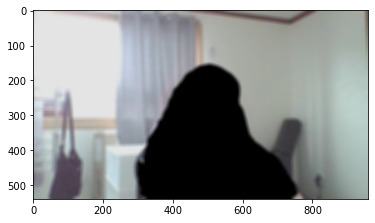

In [11]:
img_bg_blur = cv2.blur(img_bg, (13, 13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 배경과 원본 합성

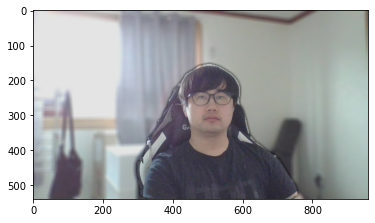

In [14]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

- np.where() 사용법   
    https://numpy.org/doc/stable/reference/generated/numpy.where.html